# Projecting Baseball WAR 

An example of bayesian forecasting with PyMC5

**Author**: *Jensen Holm* <br>
**Date**: *March 2025* 

In [76]:
import pymc as pm 
import pybaseball
import polars as pl
from plotnine import (
    ggplot,
    aes,
    geom_line,
    geom_point,
    labs,
    facet_wrap,
    geom_density,
    geom_vline,
)

## Loading Data

I am going to use [pybaseball](https://github.com/jldbc/pybaseball) to load MLB batting **W**ins **A**bove **R**eplacement statistics. This will provide us with our target variable, and a few other general baseball statistics we might use as features.

After we have our target variable (WAR), I am going to use pybaseball again to load some data that might be helpful in adding more important features to our model. 

The whole schema for this data set can be found in [fg_data_schema.md](fg_data_schema.md)

In [2]:
YR_RANGE = range(2015, 2025)
WINDOW_SIZE = 3

batting_df: pl.DataFrame = (pybaseball.batting_stats(min(YR_RANGE), max(YR_RANGE))
                            .pipe(pl.from_pandas))

# show descriptive stats about WAR and some other things
# just to get an idea of what our data looks like
(batting_df
    .select("Season", "WAR", "Age", "H", "BABIP+")
    .describe())

statistic,Season,WAR,Age,H,BABIP+
str,f64,f64,f64,f64,f64
"""count""",1375.0,1375.0,1375.0,1375.0,1375.0
"""null_count""",0.0,0.0,0.0,0.0,0.0
"""mean""",2019.394182,2.727636,28.289455,134.755636,102.340364
"""std""",2.867571,1.982112,3.654352,35.823763,11.305687
"""min""",2015.0,-2.5,20.0,32.0,69.0
"""25%""",2017.0,1.4,26.0,121.0,95.0
"""50%""",2019.0,2.5,28.0,139.0,102.0
"""75%""",2022.0,3.9,31.0,158.0,110.0
"""max""",2024.0,11.2,41.0,217.0,141.0


## Feature Engineering

In [29]:
def plyr_szn_window(df: pl.DataFrame, features: list[str], _shift: int = 3) -> pl.DataFrame:
    df = df.sort(["Name", "Season"])
    return df.with_columns([
        pl.col(f).shift(i).over("IDfg").alias(f"{f}_prev{i}")
        for i in range(1, _shift+1)
        for f in features
    ])

_fs = [col for col in batting_df.columns if col not in {"Season", "Name", "IDfg"}]
history_batting_df = batting_df.pipe(plyr_szn_window, _fs, _shift=3)

(history_batting_df
    .filter(pl.col("Name") == "Nolan Arenado")
    .select("Season", "Name", "PA", "WAR", "WAR_prev1", "WAR_prev2", "WAR_prev3"))

Season,Name,PA,WAR,WAR_prev1,WAR_prev2,WAR_prev3
i64,str,i64,f64,f64,f64,f64
2015,"""Nolan Arenado""",665,4.5,null,null,null
2016,"""Nolan Arenado""",696,6.0,4.5,null,null
2017,"""Nolan Arenado""",680,5.8,6.0,4.5,null
2018,"""Nolan Arenado""",673,5.9,5.8,6.0,4.5
2019,"""Nolan Arenado""",662,6.1,5.9,5.8,6.0
2020,"""Nolan Arenado""",201,0.6,6.1,5.9,5.8
2021,"""Nolan Arenado""",653,4.3,0.6,6.1,5.9
2022,"""Nolan Arenado""",620,7.2,4.3,0.6,6.1
2023,"""Nolan Arenado""",612,2.7,7.2,4.3,0.6


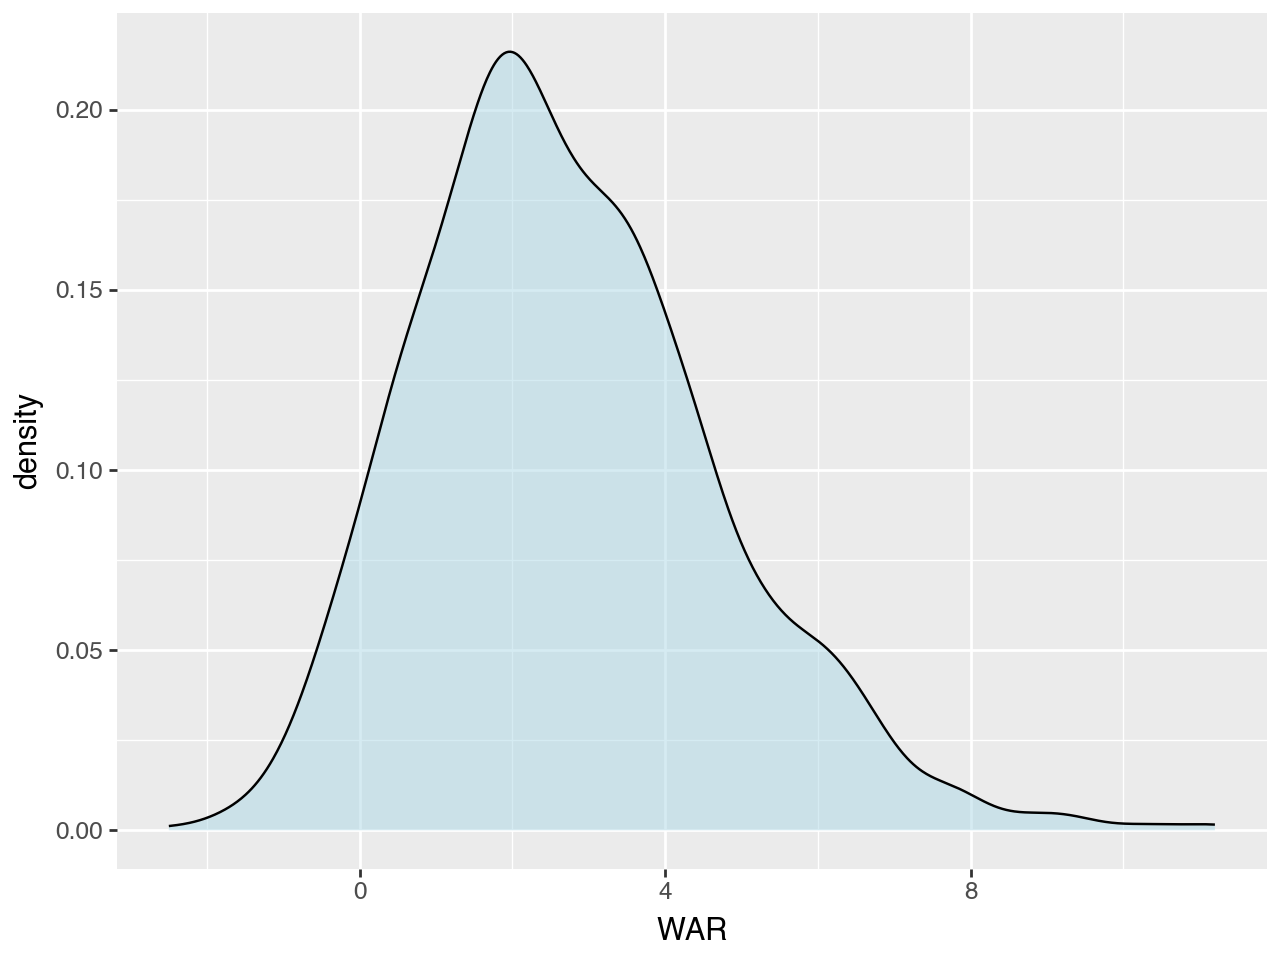

In [ ]:

war_dist_plot = (
    ggplot(batting_df, aes(x="WAR", fill=factor))
    + geom_vline(xintercept=)
    + geom_density(alpha=0.5, fill="lightblue")
    +labs()
)

war_dist_plot.show()